<a href="https://colab.research.google.com/github/AditiG10/Classification-of-COVID-19-chest-X-ray-images/blob/master/DenseNEt201_RMS_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import libraries
import json
import math
import os
import random
from glob import glob 
from tqdm import tqdm
from PIL import Image
import cv2 # image processing
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt # data visualization


from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report 
from sklearn.model_selection import train_test_split

from keras import layers
from keras.models import Sequential
from keras.optimizers import Adam, RMSprop
from keras.applications import DenseNet201
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.utils.np_utils import to_categorical
from keras.layers import  Conv2D,MaxPooling2D,Activation,Dropout,Flatten,Dense,BatchNormalization
from keras.preprocessing.image import ImageDataGenerator,image,img_to_array,load_img



Using TensorFlow backend.


In [2]:
!git clone https://github.com/vaibhavG321/Classification-of-COVID-19-chest-X-ray-images

Cloning into 'Classification-of-COVID-19-chest-X-ray-images'...
remote: Enumerating objects: 331, done.
remote: Total 331 (delta 0), reused 0 (delta 0), pack-reused 331
Receiving objects: 100% (331/331), 80.94 MiB | 10.34 MiB/s, done.
Resolving deltas: 100% (16/16), done.


In [3]:
cd Classification-of-COVID-19-chest-X-ray-images 

/content/Classification-of-COVID-19-chest-X-ray-images


In [4]:
cd dataset

/content/Classification-of-COVID-19-chest-X-ray-images/dataset


In [5]:
input_dir = "/content/Classification-of-COVID-19-chest-X-ray-images/dataset/"
train_dir = "/content/Classification-of-COVID-19-chest-X-ray-images/dataset/training"
test_dir = "/content/Classification-of-COVID-19-chest-X-ray-images/dataset/testing"
val_dir = "/content/Classification-of-COVID-19-chest-X-ray-images/dataset/evaluation"

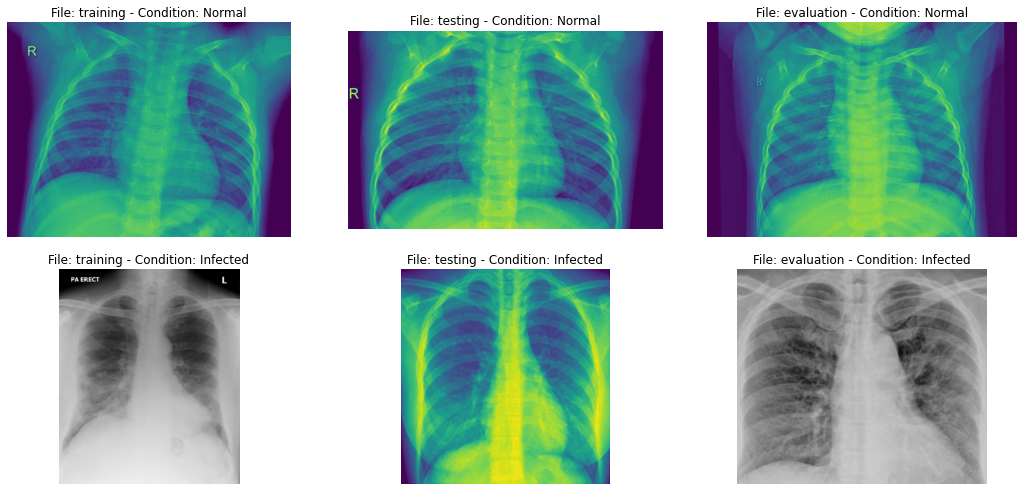

In [6]:
fig, ax = plt.subplots(2,3, figsize=(15,7))
ax = ax.ravel()
plt.tight_layout()
for i, _set in enumerate(['training','testing','evaluation']):
    set_path = input_dir+_set
    ax[i].axis('off')
    ax[i].imshow(plt.imread(set_path+'/normal/'+os.listdir(set_path+'/normal')[0]))
    ax[i].set_title('File: {} - Condition: Normal'.format(_set))
    ax[i+3].axis('off')
    ax[i+3].imshow(plt.imread(set_path+'/infected/'+os.listdir(set_path+'/infected')[0]))
    ax[i+3].set_title('File: {} - Condition: Infected'.format(_set))

In [7]:
# Data Augmentation
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=8,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        val_dir,
        target_size=(224, 224),
        batch_size=8,
        class_mode='binary')

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        batch_size=8,
        class_mode='binary')

Found 187 images belonging to 2 classes.
Found 2 images belonging to 2 classes.
Found 94 images belonging to 2 classes.


In [8]:
import tensorflow as tf

In [10]:
# Create DenseNet201 Model with Keras library

def build_model(backbone, lr=1e-4):
    model = Sequential()
    model.add(backbone)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=RMSprop(lr=lr),
        metrics=['acc']
    )
    return model

densenet = DenseNet201(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

model = build_model(densenet ,lr = 1e-4)
model.summary()

74842112/74836368 [==============================] - 6s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Model)          (None, 7, 7, 1920)        18321984  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1920)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1920)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1920)              7680      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1921      
Total params: 18,331,585
Trainable params: 18,098,689
Non-trainable params: 232,896
_________________________________________________________________


In [12]:
# Fit Model
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=5,
    validation_data=test_generator,
    validation_steps=5
)

Epoch 1/5
100/100 [==============================] - 873s 9s/step - loss: 0.0956 - acc: 0.9690 - val_loss: 0.0050 - val_acc: 1.0000
Epoch 2/5
100/100 [==============================] - 881s 9s/step - loss: 0.1168 - acc: 0.9618 - val_loss: 0.0931 - val_acc: 0.9750
Epoch 3/5
100/100 [==============================] - 875s 9s/step - loss: 0.1127 - acc: 0.9626 - val_loss: 0.0223 - val_acc: 0.9474
Epoch 4/5
100/100 [==============================] - 876s 9s/step - loss: 0.0812 - acc: 0.9731 - val_loss: 0.0194 - val_acc: 1.0000
Epoch 5/5
100/100 [==============================] - 884s 9s/step - loss: 0.0668 - acc: 0.9782 - val_loss: 0.5602 - val_acc: 0.9737


In [13]:
score = model.evaluate_generator(test_generator,verbose=1)
print("The accuracy is ",score[1])

12/12 [==============================] - 29s 2s/step
The accuracy is  0.9680851101875305


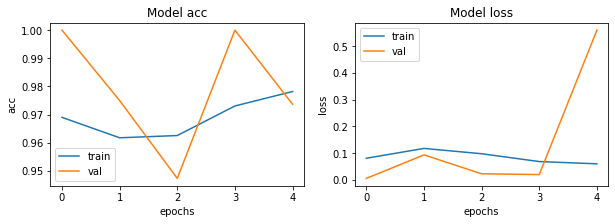

In [14]:
# Visualize Loss and Accuracy Rates
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['acc', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [15]:
# model save
model.save_weights("cnn-covid-19-xray-densenet201.h5")

Actual class: normal
Predicted class: normal
Likelihood: 0.0
WARNING, low confidence


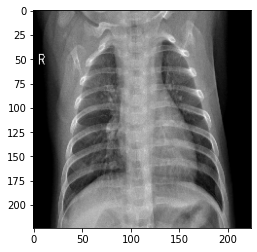

In [16]:
def choose_image_and_predict():
    normal_or_covid = ['normal', 'covid']
    folder_choice = (random.choice(normal_or_covid))
    
    covid_images = glob(r'/content/Classification-of-COVID-19-chest-X-ray-images/dataset/testing/'+folder_choice+'/*')
    img_choice = (random.choice(covid_images))

    img = load_img(img_choice, target_size=(224, 224))
    img = img_to_array(img)
    plt.imshow(img / 255.)
    x = preprocess_input(np.expand_dims(img.copy(), axis=0))
    pred_class = model.predict_classes(x)
    pred = model.predict(x)
    print("Actual class:", folder_choice)
    if pred_class[0] == 0:
        print("Predicted class: normal")
        print("Likelihood:", pred[0][0].round(4))
        if pred[0][0].round(4) < 0.8:
            print("WARNING, low confidence")
    else:
        print("Predicted class: covid")
        print('Likelihood:', pred[0][1].round(4))
        if pred[0][1].round(4) < 0.8:
            print("WARNING, low confidence")        
        
choose_image_and_predict()